## Imports

In [223]:
# multivariate output data prep
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## Reading Data

In [156]:
# Load data from CSV
df = pd.read_csv('data/clean_data.csv')

In [157]:
df.head(10)

,T,TM,Tm,H,PP,VV,V,VM,RA,SN,TS,FG,train,Date
0,20.8,27.0,15.3,56.0,0.0,6.3,4.8,11.1,0.0,0.0,0.0,0.0,1,2008-01-01
1,20.1,27.6,14.0,55.0,0.0,6.3,5.2,9.4,0.0,0.0,0.0,0.0,1,2008-01-02
2,20.3,28.3,13.8,55.0,0.0,6.3,5.0,7.6,0.0,0.0,0.0,0.0,1,2008-01-03
3,21.3,26.3,16.0,78.0,0.0,5.8,6.3,11.1,1.0,0.0,0.0,0.0,1,2008-01-04
4,20.4,26.6,16.8,65.0,0.0,5.5,5.0,7.6,1.0,0.0,0.0,0.0,1,2008-01-05
5,19.9,26.9,15.0,63.0,0.0,6.3,6.7,9.4,0.0,0.0,0.0,0.0,1,2008-01-06
6,19.7,27.2,14.7,59.0,0.0,5.5,7.2,11.1,0.0,0.0,0.0,0.0,1,2008-01-07
7,19.9,25.6,14.7,62.0,0.0,4.8,7.2,11.1,0.0,0.0,0.0,0.0,1,2008-01-08
8,20.3,28.4,14.3,60.0,0.0,6.3,5.7,9.4,0.0,0.0,0.0,0.0,1,2008-01-09
9,21.3,29.9,15.5,58.0,0.0,6.3,5.0,11.1,0.0,0.0,0.0,0.0,1,2008-01-10


In [158]:
df.set_index(keys="Date", drop=True, inplace=True)

In [159]:
df.head()

,T,TM,Tm,H,PP,VV,V,VM,RA,SN,TS,FG,train
Date,,,,,,,,,,,,,
2008-01-01,20.8,27.0,15.3,56.0,0.0,6.3,4.8,11.1,0.0,0.0,0.0,0.0,1
2008-01-02,20.1,27.6,14.0,55.0,0.0,6.3,5.2,9.4,0.0,0.0,0.0,0.0,1
2008-01-03,20.3,28.3,13.8,55.0,0.0,6.3,5.0,7.6,0.0,0.0,0.0,0.0,1
2008-01-04,21.3,26.3,16.0,78.0,0.0,5.8,6.3,11.1,1.0,0.0,0.0,0.0,1
2008-01-05,20.4,26.6,16.8,65.0,0.0,5.5,5.0,7.6,1.0,0.0,0.0,0.0,1


## Splitting train-test

In [160]:
# Train-test split
train, test = df[df["train"]==1], df[df["train"] == 0]

In [161]:
train.shape, test.shape

((5479, 13), (335, 13))

In [162]:
train.drop(axis=0, columns=["train"], inplace=True)
test.drop(axis=0, columns=["train"], inplace=True)

/var/folders/8y/3b6b9p6d5vjg7ql8yvqrf69w0000gn/T/ipykernel_1091/8036289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(axis=0, columns=["train"], inplace=True)
/var/folders/8y/3b6b9p6d5vjg7ql8yvqrf69w0000gn/T/ipykernel_1091/8036289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(axis=0, columns=["train"], inplace=True)


In [163]:
train.shape, test.shape

((5479, 12), (335, 12))

## Data Preperation

In [164]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [199]:
n_steps = 7

dataset = train.values#.reshape(train.shape[1], train.shape[0])

X, y = split_sequences(dataset, n_steps)

In [200]:
X.shape, y.shape

((5472, 7, 12), (5472, 12))

## LSTM Model

- n_features : number of features we are passing to the network
- n_steps : for how may days of data model shouldbe trained on (in out case we are passing 7 days of data then it will predict for next 8<sup>th</sup> day)
- in dense layer we need to expect 12 out comes as our preiction for 8<sup>th</sup> day, meaning we want 12 different features to be predicted on day 8

In [201]:
n_features = train.shape[1]
n_steps = 7 # number of past days data

print(f"Number of input features: {n_features}")
print(f"Number of days: {n_steps}")

Number of input features: 12
Number of days: 7


In [202]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [203]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 7, 100)            45200     
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 12)                1212      
                                                                 
Total params: 126812 (495.36 KB)
Trainable params: 126812 (495.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [204]:
X.shape, y.shape

((5472, 7, 12), (5472, 12))

In [206]:
# fit model
model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
171/171 [==============================] - 1s 5ms/step - loss: 15.2597
Epoch 2/100
171/171 [==============================] - 1s 4ms/step - loss: 15.2402
Epoch 3/100
171/171 [==============================] - 1s 4ms/step - loss: 15.3473
Epoch 4/100
171/171 [==============================] - 1s 4ms/step - loss: 15.0404
Epoch 5/100
171/171 [==============================] - 1s 4ms/step - loss: 14.9267
Epoch 6/100
171/171 [==============================] - 1s 4ms/step - loss: 14.8251
Epoch 7/100
171/171 [==============================] - 1s 4ms/step - loss: 14.7251
Epoch 8/100
171/171 [==============================] - 1s 4ms/step - loss: 14.6848
Epoch 9/100
171/171 [==============================] - 1s 4ms/step - loss: 14.5640
Epoch 10/100
171/171 [==============================] - 1s 4ms/step - loss: 14.7397
Epoch 11/100
171/171 [==============================] - 1s 4ms/step - loss: 14.5842
Epoch 12/100
171/171 [==============================] - 1s 4ms/step - loss: 14.6866
E

In [220]:
# demonstrate prediction
x_input, _ = split_sequences(test.values, n_steps)
yhat = model.predict(x_input, verbose=0)

In [221]:
yhat

array([[ 2.11933670e+01,  2.67555580e+01,  1.74346581e+01, ...,
        -1.07984245e-02,  2.79984474e-02,  7.07458705e-04],
       [ 2.14162903e+01,  2.71122704e+01,  1.73993301e+01, ...,
        -1.06463879e-02,  3.98159698e-02,  9.97056067e-03],
       [ 2.05197334e+01,  2.72263069e+01,  1.49750328e+01, ...,
        -1.20163709e-03,  2.00200602e-02, -1.68746337e-02],
       ...,
       [ 2.22924919e+01,  2.83559837e+01,  1.83756657e+01, ...,
         1.30377710e-04,  1.25617146e-01, -4.95515764e-03],
       [ 2.16598167e+01,  2.74383583e+01,  1.80483780e+01, ...,
        -5.77946007e-03,  7.13727996e-02,  4.25665546e-03],
       [ 2.18549995e+01,  2.75115471e+01,  1.82774315e+01, ...,
        -1.31664425e-03,  9.81671736e-02, -1.81443151e-03]], dtype=float32)

In [224]:
pred_df = pd.DataFrame(yhat,columns=test.columns)

In [225]:
pred_df.head()

,T,TM,Tm,H,PP,VV,V,VM,RA,SN,TS,FG
0,21.193367,26.755558,17.434658,66.810081,0.153342,6.079968,6.802482,10.545158,0.414033,-0.010798,0.027998,0.000707
1,21.416290,27.112270,17.399330,64.467651,-0.395458,6.033896,5.535951,8.757828,0.383389,-0.010646,0.039816,0.009971
2,20.519733,27.226307,14.975033,50.974045,1.196450,6.250165,3.450049,6.845623,0.141188,-0.001202,0.020020,-0.016875
3,20.355019,26.833820,15.421325,58.257820,-0.915854,6.220373,5.205995,8.333843,0.246855,0.013413,0.043358,-0.019910
4,20.181557,26.974525,14.527432,50.302551,1.482141,6.265300,3.978437,7.716433,0.151453,0.009900,0.018051,-0.020291


## Visualize Results

In [228]:
test = test.iloc[:pred_df.shape[0],:]

In [229]:
test.shape, pred_df.shape

((328, 12), (328, 12))

<Figure size 1200x800 with 0 Axes>

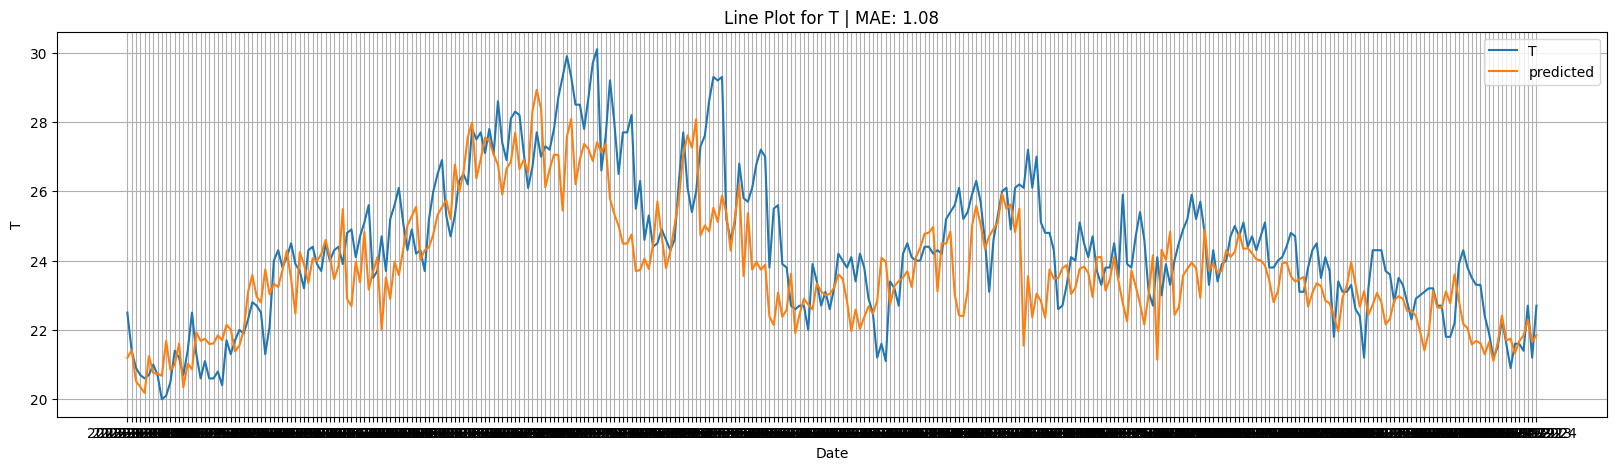

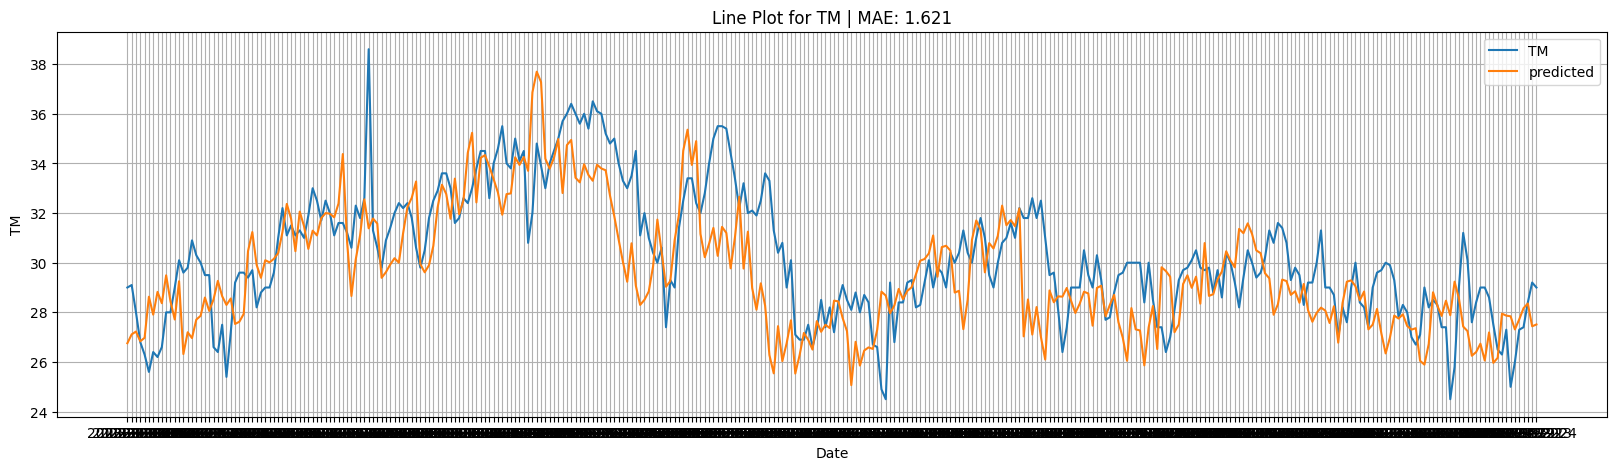

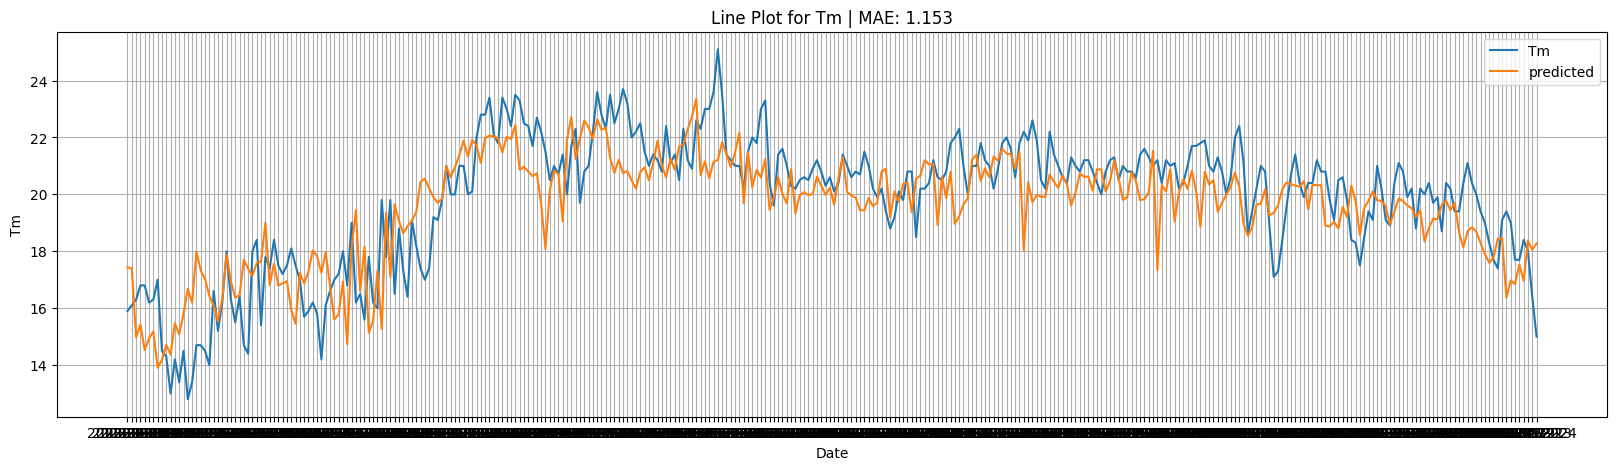

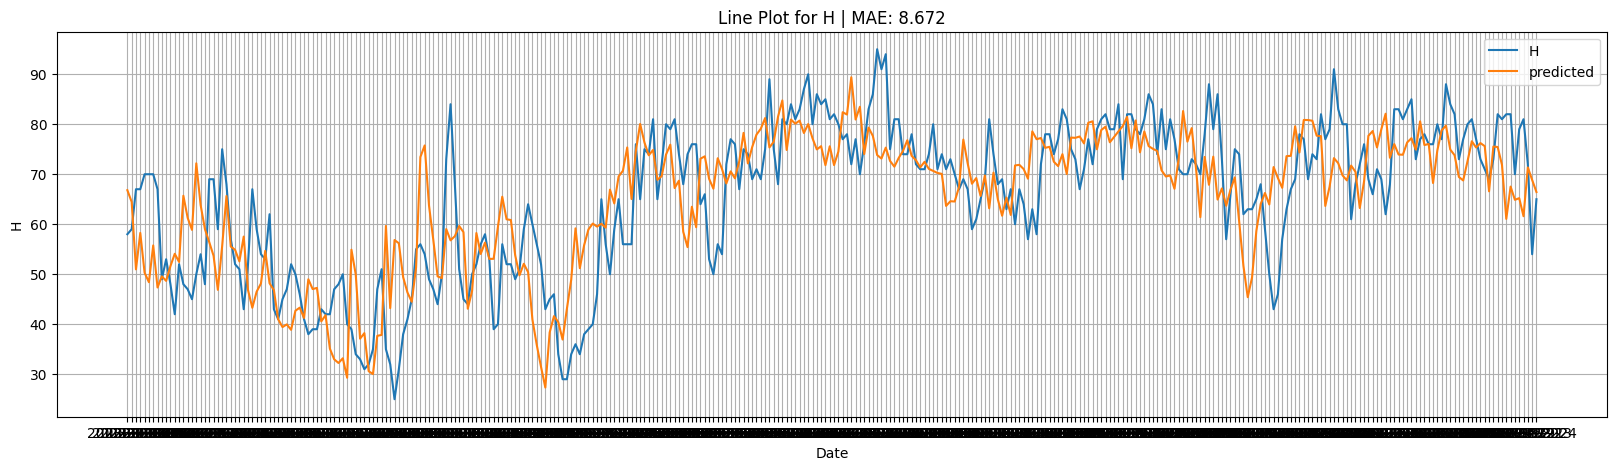

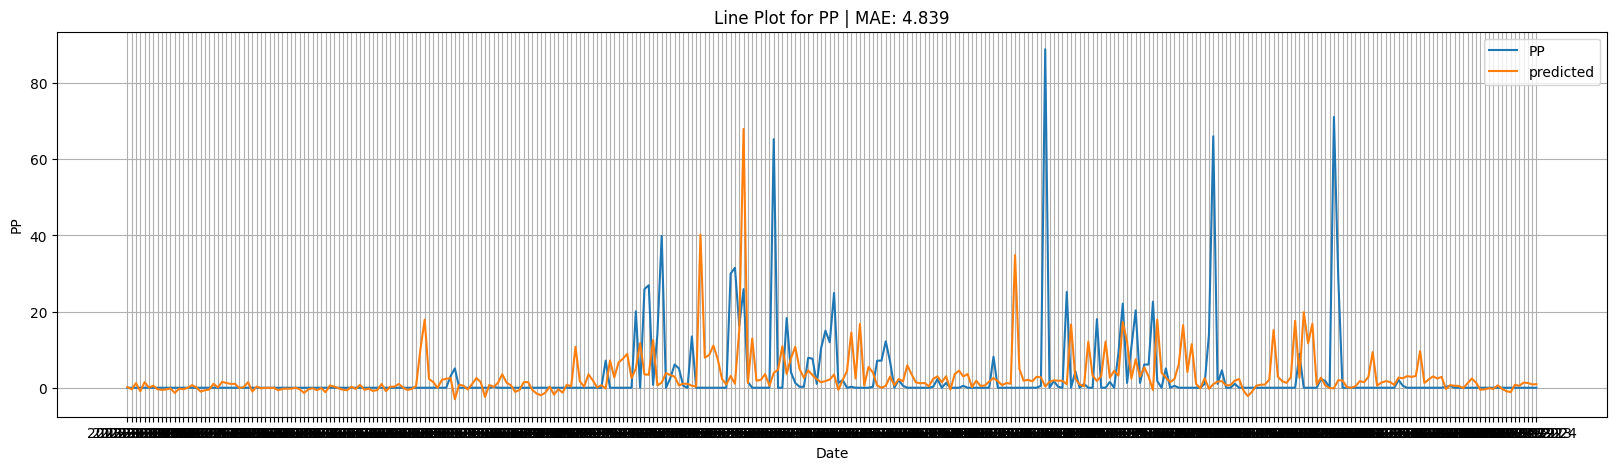

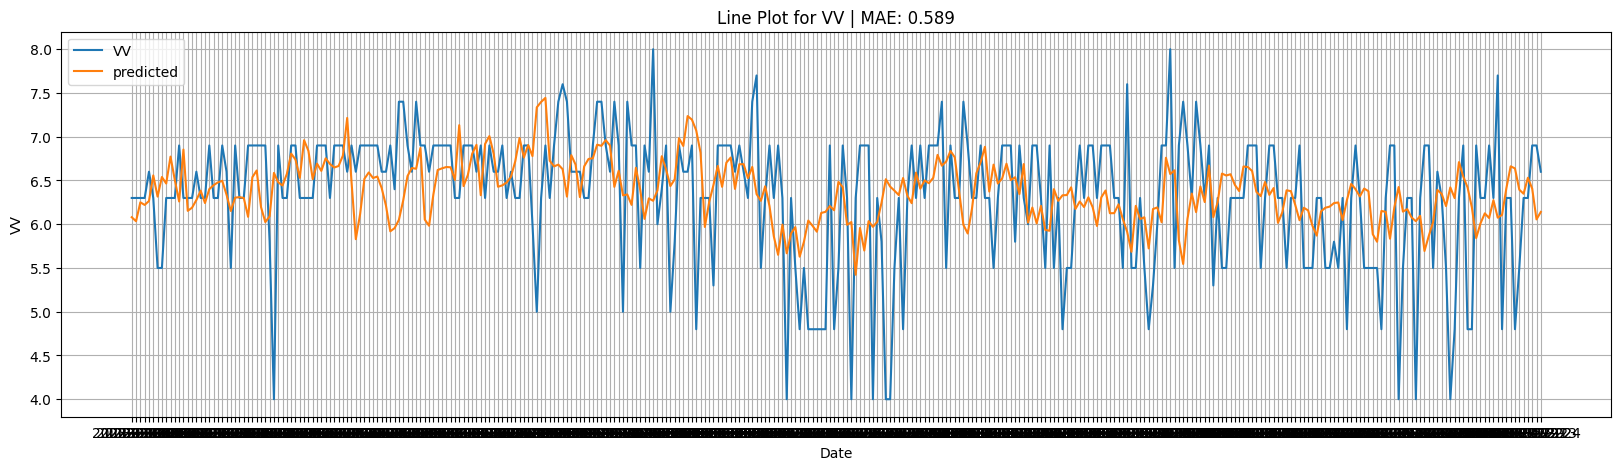

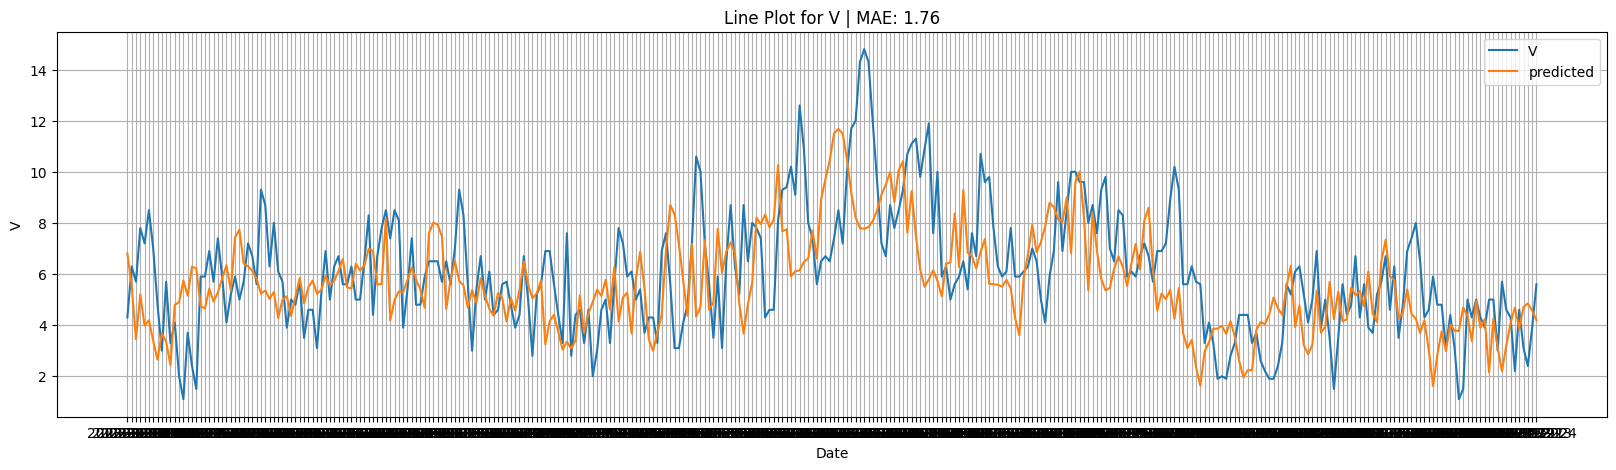

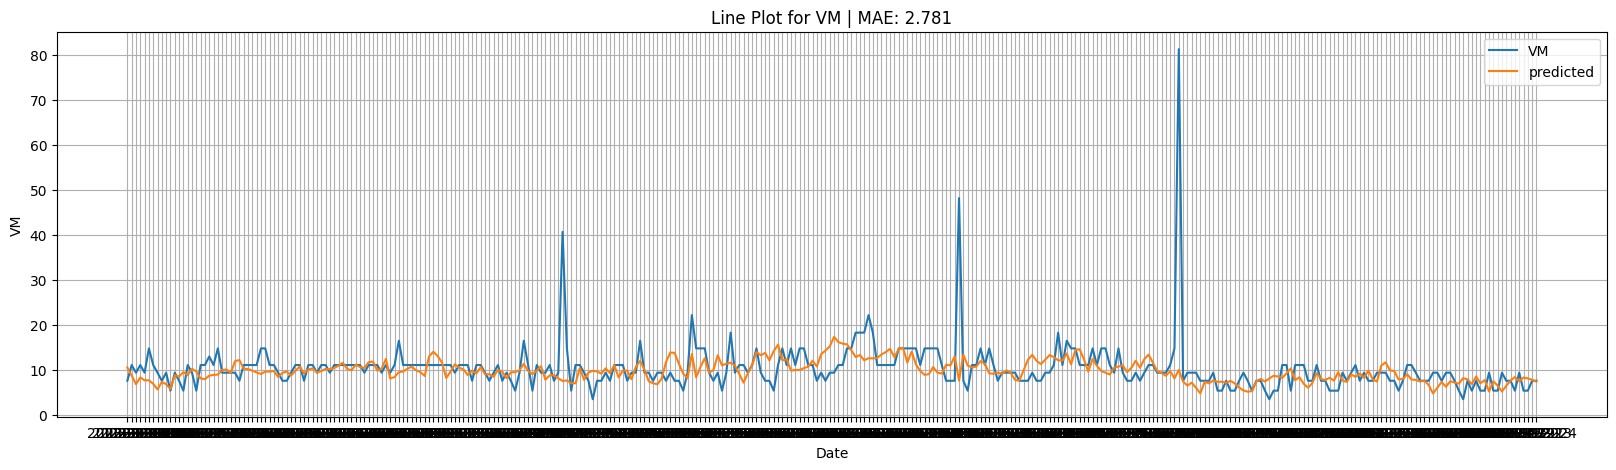

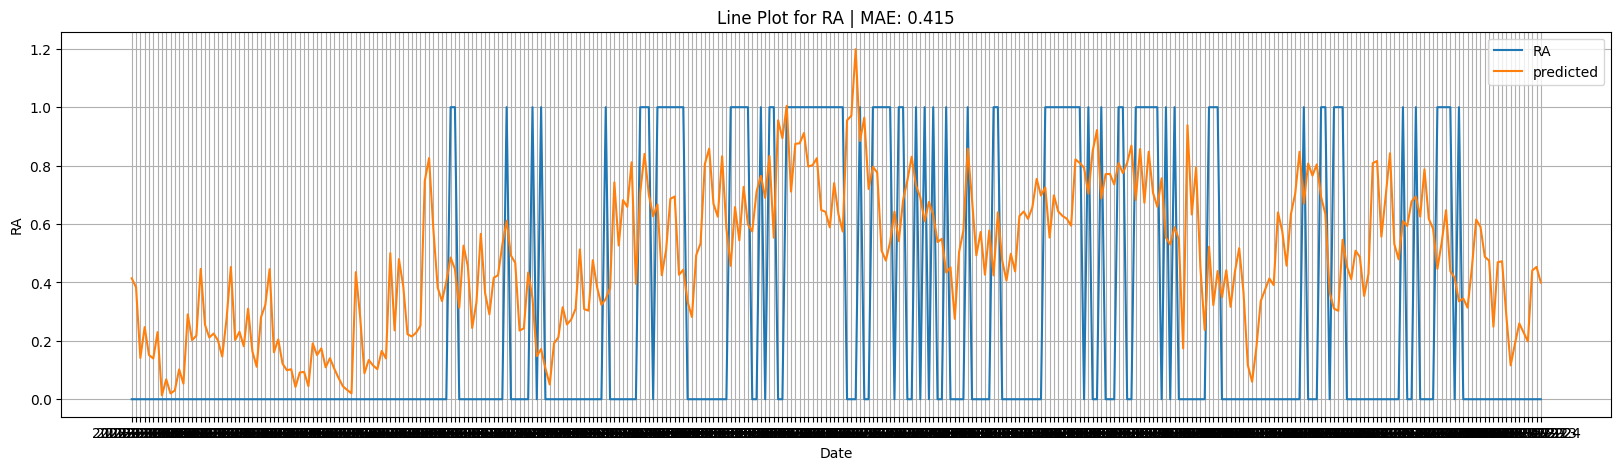

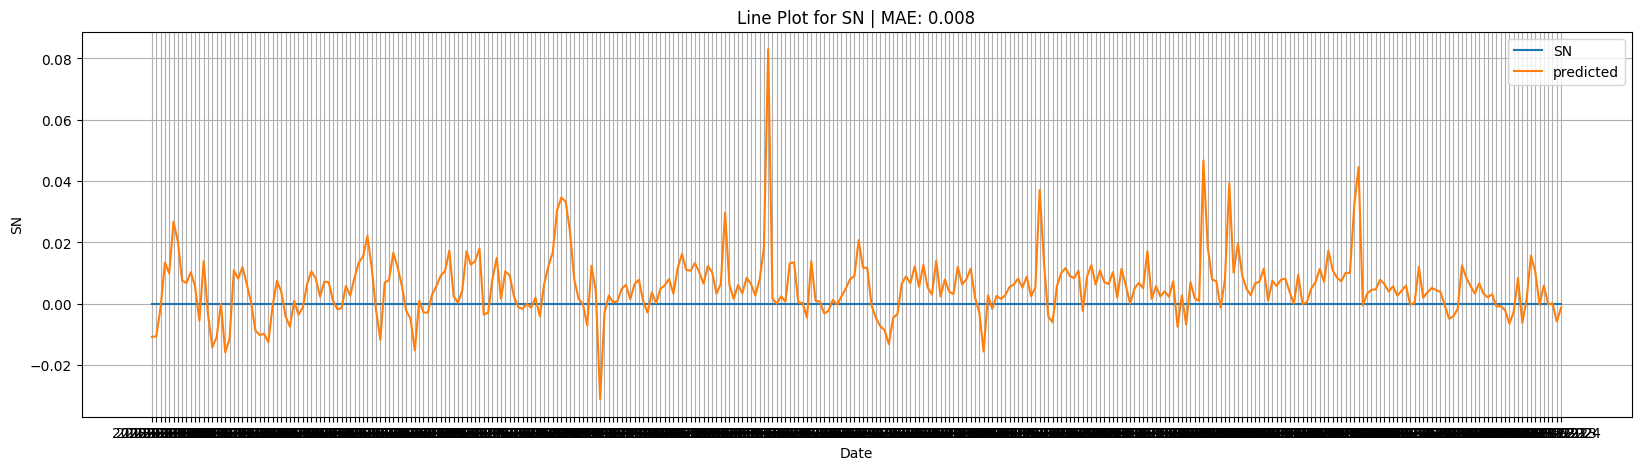

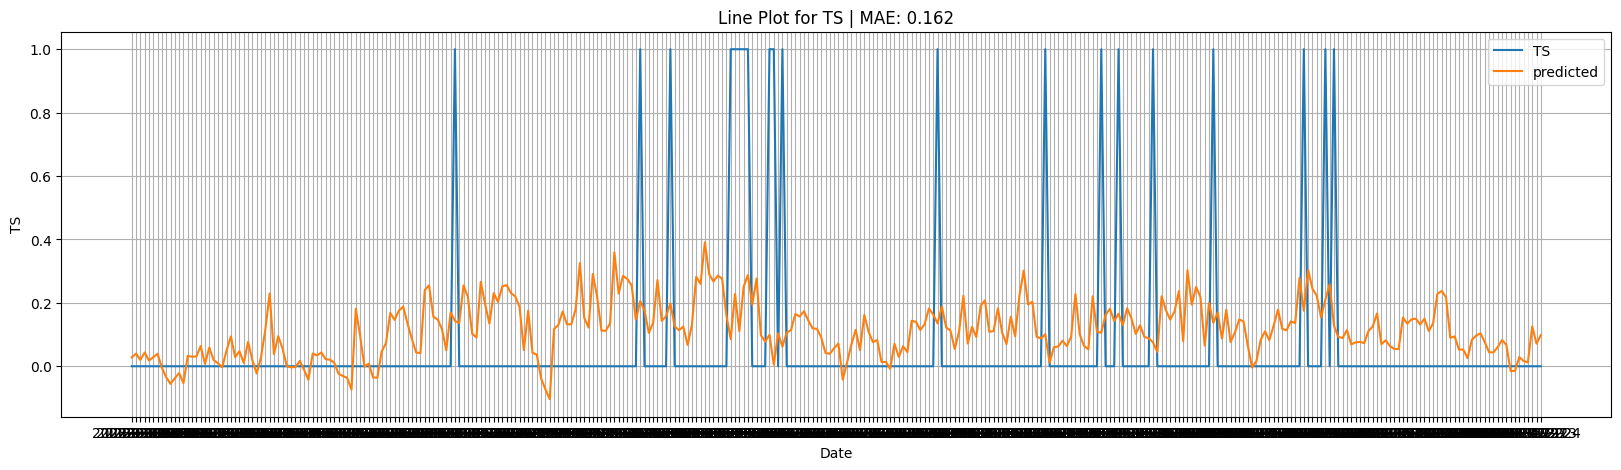

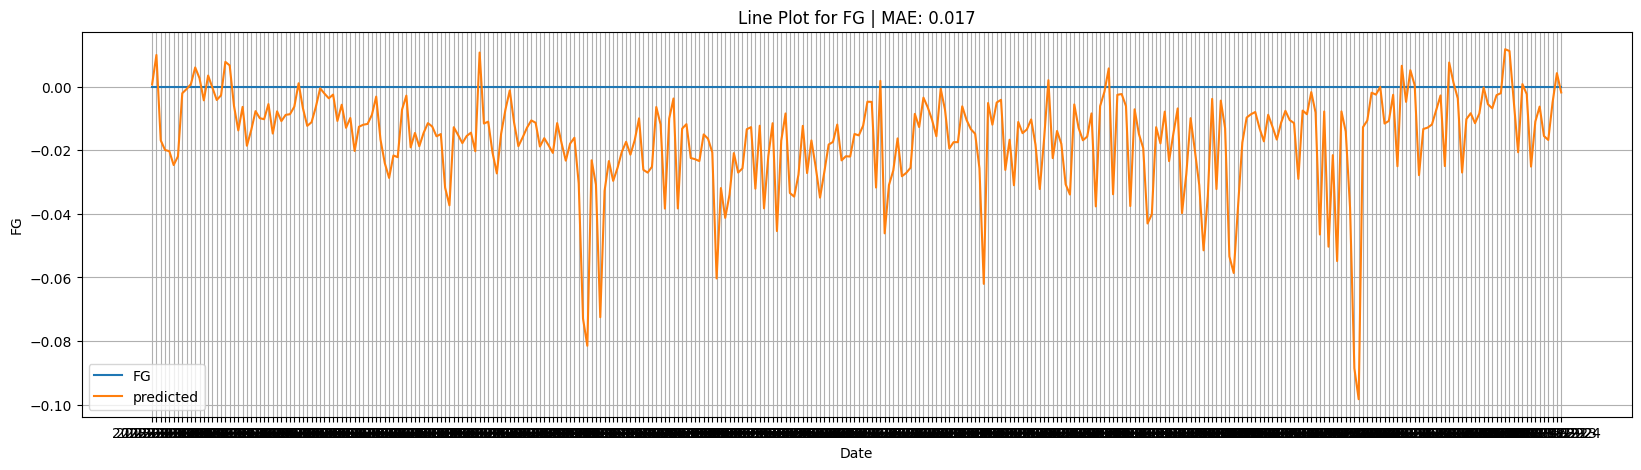

In [230]:
features = test.columns

plt.figure(figsize=(12, 8))

for feature in features:
    plt.figure(figsize=(20, 5))
    plt.plot(test.index, test[feature], label=feature)
    plt.plot(pred_df.index, pred_df[feature], label="predicted")
    plt.title(f'Line Plot for {feature} | MAE: {np.round(mean_absolute_error(test[feature],pred_df[feature]), 3)}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid()
    plt.show()

## Example Modeling

In [153]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# print model summary
model.summary()
# fit model
model.fit(X, y, epochs=400, verbose=1)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 100)            41600     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 122303 (477.75 KB)
Trainable params: 122303 (477.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/400
1/1 [==============================] - 1s 781ms/step - loss: 10442.4893
Epoch 2/400
1/1 [==============================] - 0s 3ms/step - loss: 10045.8047
Epoch 3/400
1/1 [==============================] - 0s 3ms/step - loss: 9820.6963
Epoch 4/400
1/1 [==============

## Deep Learning Approaches

In [114]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, RNN
import matplotlib.pyplot as plt
import numpy as np

### 7. Long Short-Term Memory (LSTM) Networks

In [119]:
# Reshape data for LSTM [samples, time steps, features]
X_train = train.values.reshape((train.shape[0], 1, train.shape[1]))
X_test = test.values.reshape((test.shape[0], 1, test.shape[1]))

In [120]:
X_train.shape, X_test.shape

((5479, 1, 12), (335, 1, 12))

In [121]:
(X_train.shape[1], X_train.shape[2])

(1, 12)

In [132]:
# Build LSTM model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(12))  # Output layer for 12 variables
model.compile(optimizer='adam', loss='mse')

In [133]:
# Fit the model
history = model.fit(X_train, train.values, epochs=200, verbose=1, validation_data=(X_test, X_test))

Epoch 1/200
172/172 [==============================] - 0s 951us/step - loss: 457.5181 - val_loss: 239.5827
Epoch 2/200
172/172 [==============================] - 0s 522us/step - loss: 103.2624 - val_loss: 33.9941
Epoch 3/200
172/172 [==============================] - 0s 510us/step - loss: 19.3916 - val_loss: 30.1811
Epoch 4/200
172/172 [==============================] - 0s 510us/step - loss: 14.5940 - val_loss: 31.3066
Epoch 5/200
172/172 [==============================] - 0s 507us/step - loss: 11.3249 - val_loss: 32.1350
Epoch 6/200
172/172 [==============================] - 0s 508us/step - loss: 9.1241 - val_loss: 33.5369
Epoch 7/200
172/172 [==============================] - 0s 510us/step - loss: 7.2099 - val_loss: 33.5887
Epoch 8/200
172/172 [==============================] - 0s 504us/step - loss: 6.2312 - val_loss: 33.5561
Epoch 9/200
172/172 [==============================] - 0s 511us/step - loss: 5.4730 - val_loss: 34.2683
Epoch 10/200
172/172 [==============================] - 

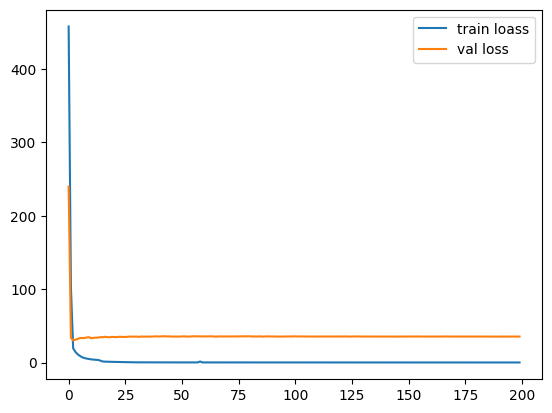

In [134]:
plt.plot(history.history['loss'], label="train loass")
plt.plot(history.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [135]:
# Predictions
predictions = model.predict(X_test)
print(predictions)

11/11 [==============================] - 0s 452us/step
[[ 2.2212170e+01  2.8175362e+01  1.7398056e+01 ...  8.1362184e-03
  -4.4016838e-02  6.9386885e-04]
 [ 2.2029890e+01  2.7699287e+01  1.7407078e+01 ...  1.0035652e-02
  -7.8747451e-02  5.7638809e-04]
 [ 2.1449965e+01  2.6760342e+01  1.7459389e+01 ...  9.1908835e-03
  -4.7721624e-02 -7.4648857e-04]
 ...
 [ 2.2168653e+01  2.7408020e+01  1.8643555e+01 ...  8.4633026e-03
   2.8439641e-02 -4.1455626e-03]
 [ 2.2812752e+01  2.8330467e+01  1.8720776e+01 ...  9.3174232e-03
  -1.2924731e-02 -3.2972433e-03]
 [ 2.2121687e+01  2.7679165e+01  1.8126274e+01 ...  7.7700759e-03
   1.5543163e-02 -2.2945851e-03]]


In [136]:
pred_df = pd.DataFrame(predictions,columns=test.columns)

In [137]:
X_test.shape, pred_df.shape

((335, 1, 12), (335, 12))

<Figure size 1200x800 with 0 Axes>

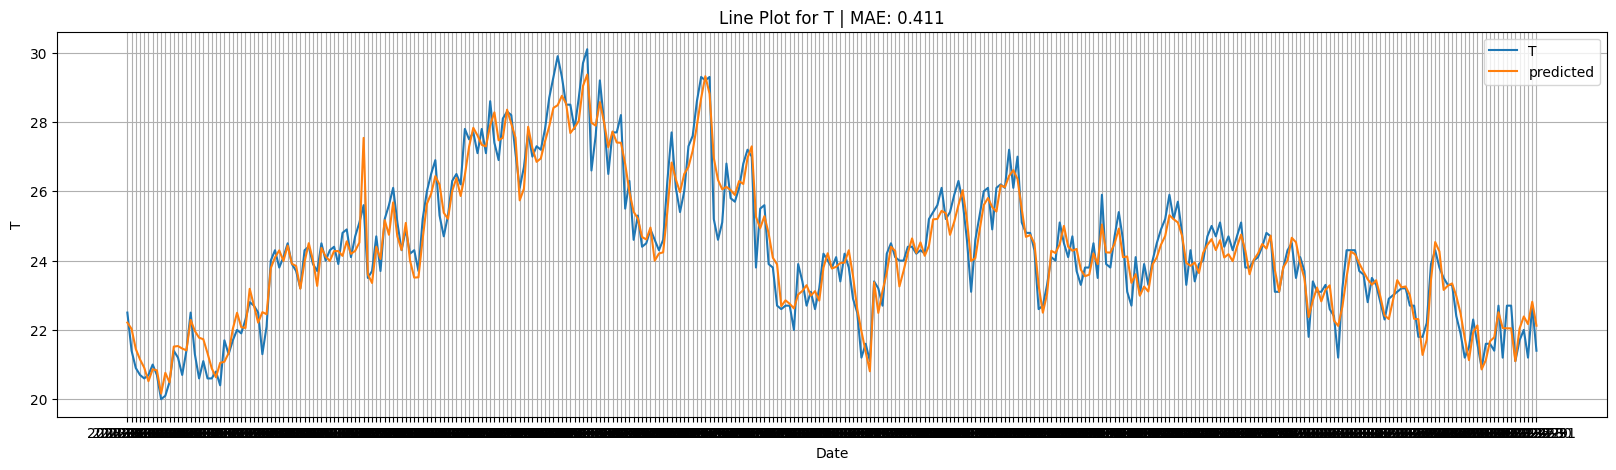

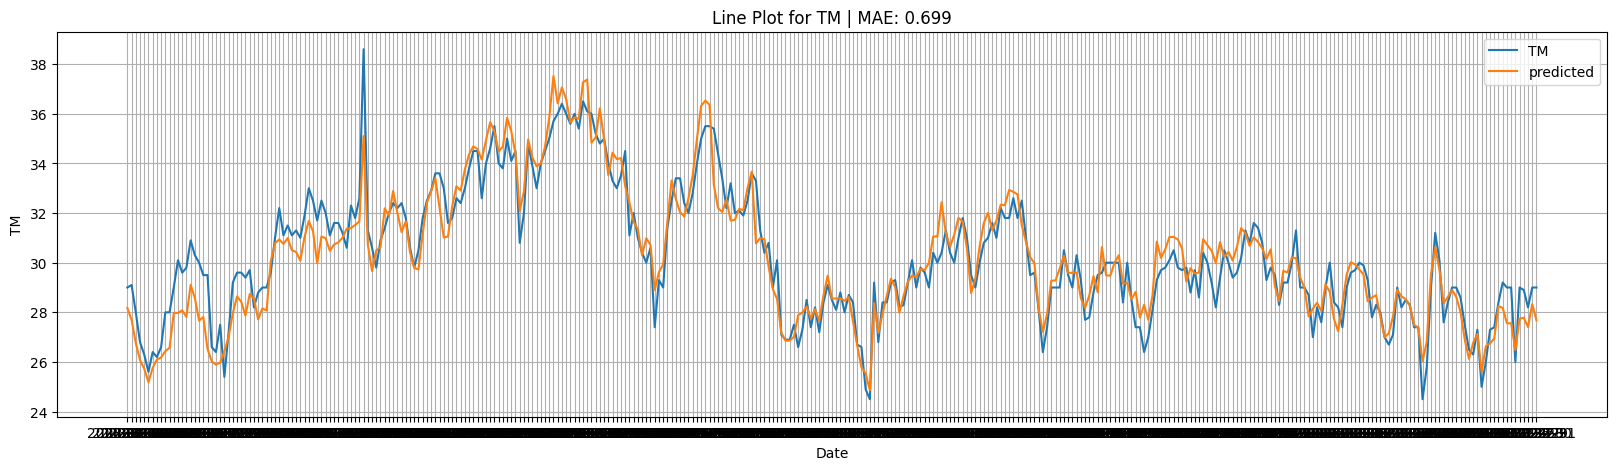

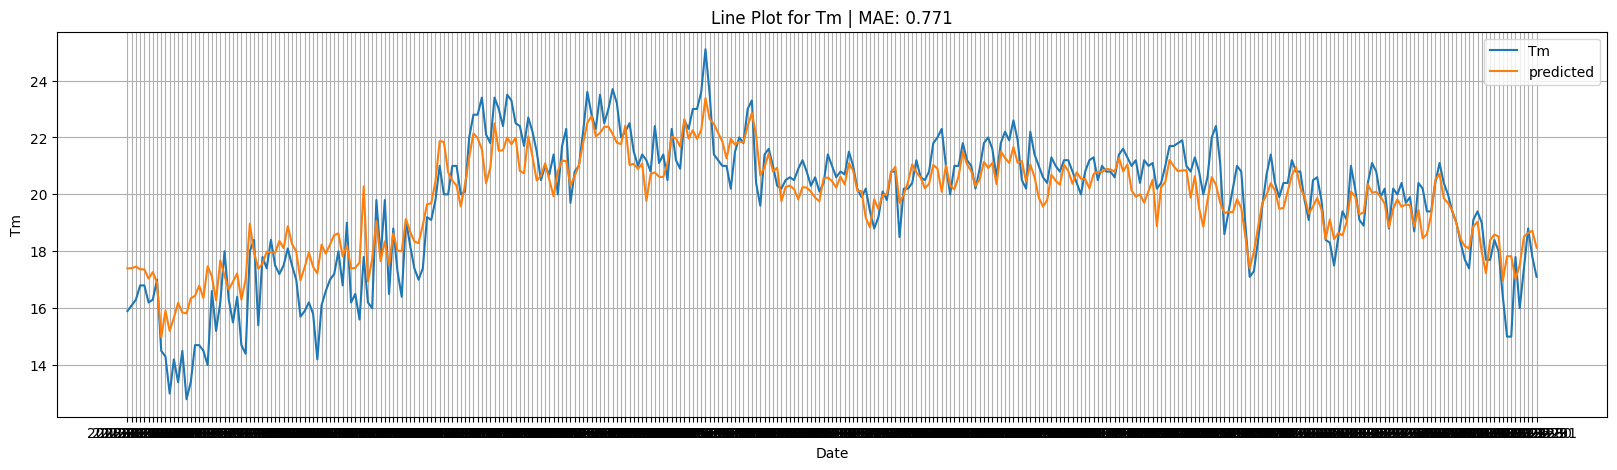

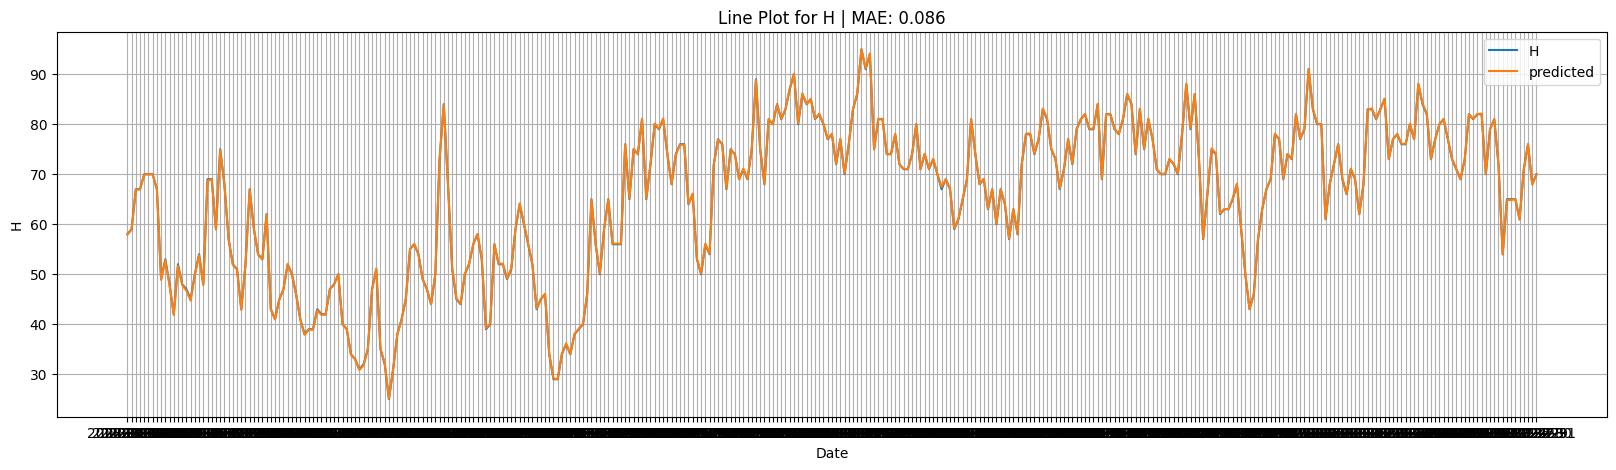

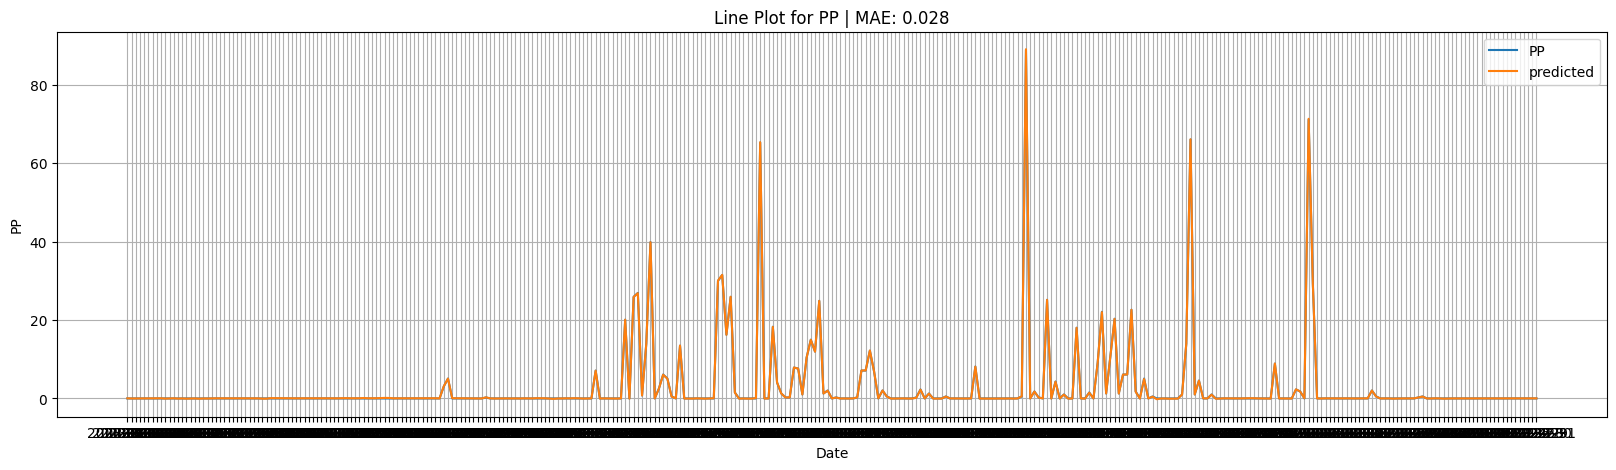

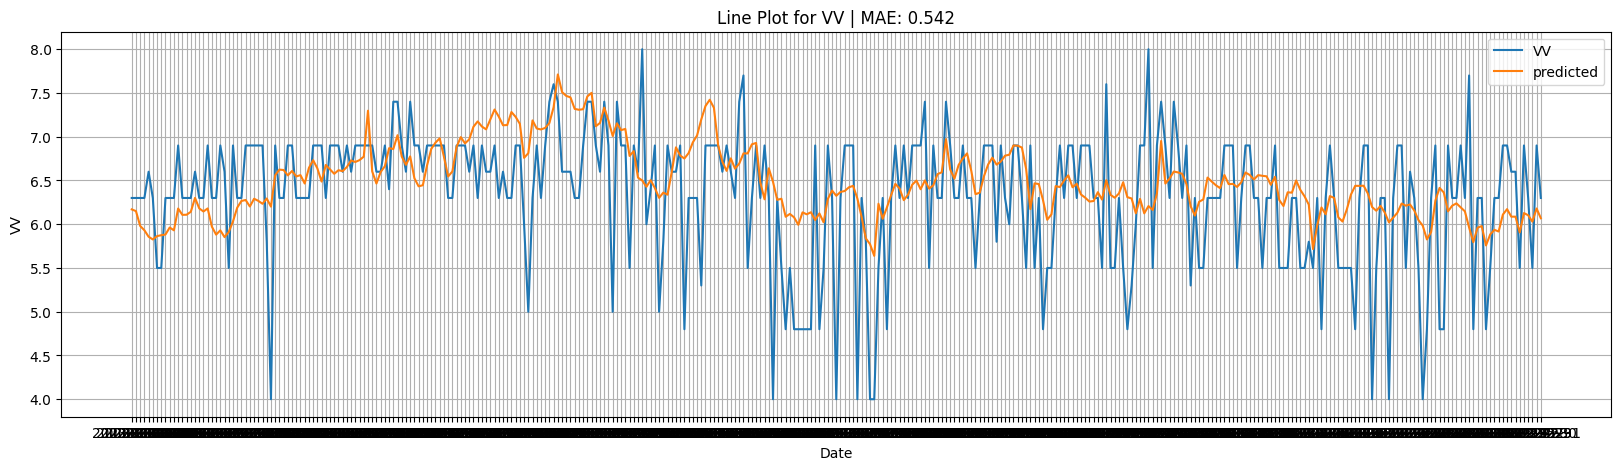

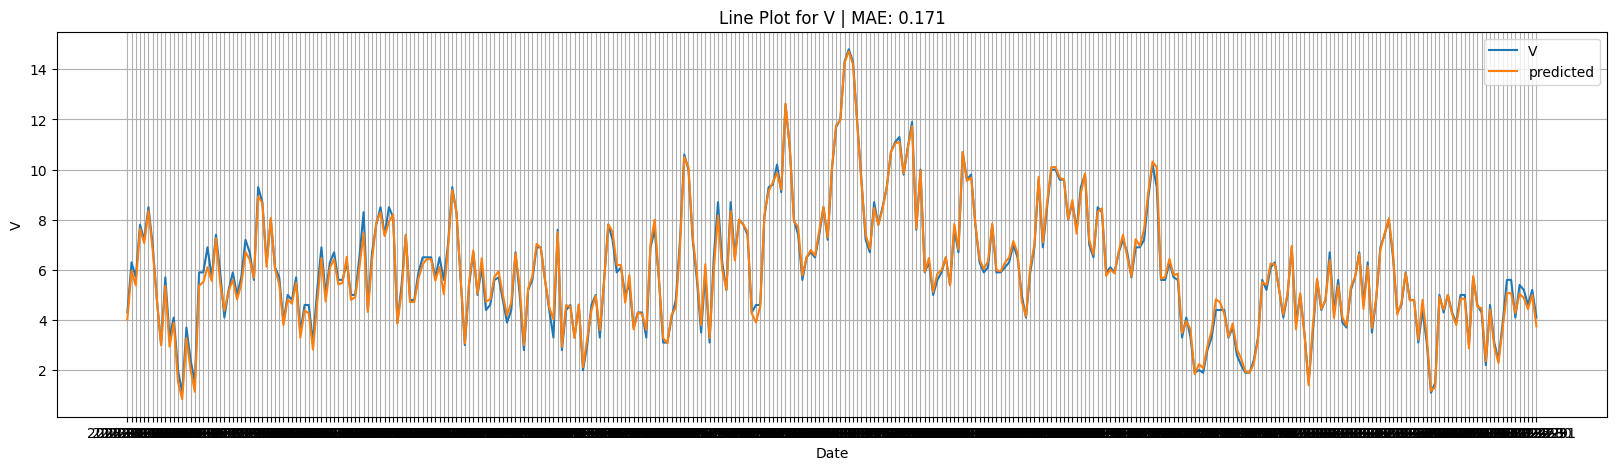

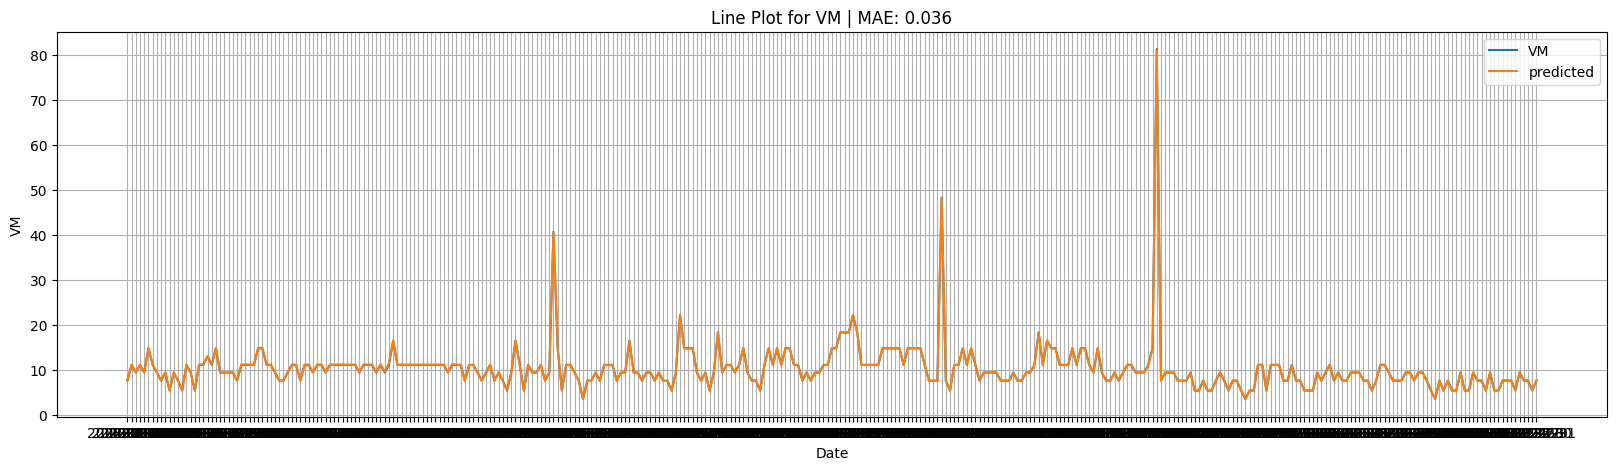

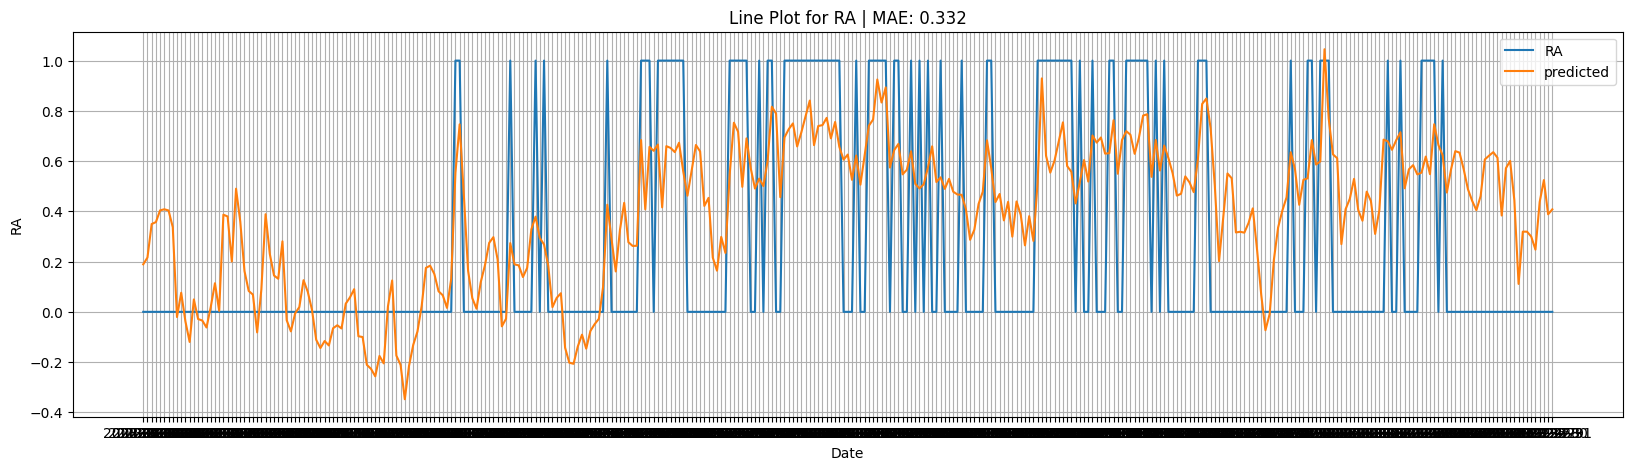

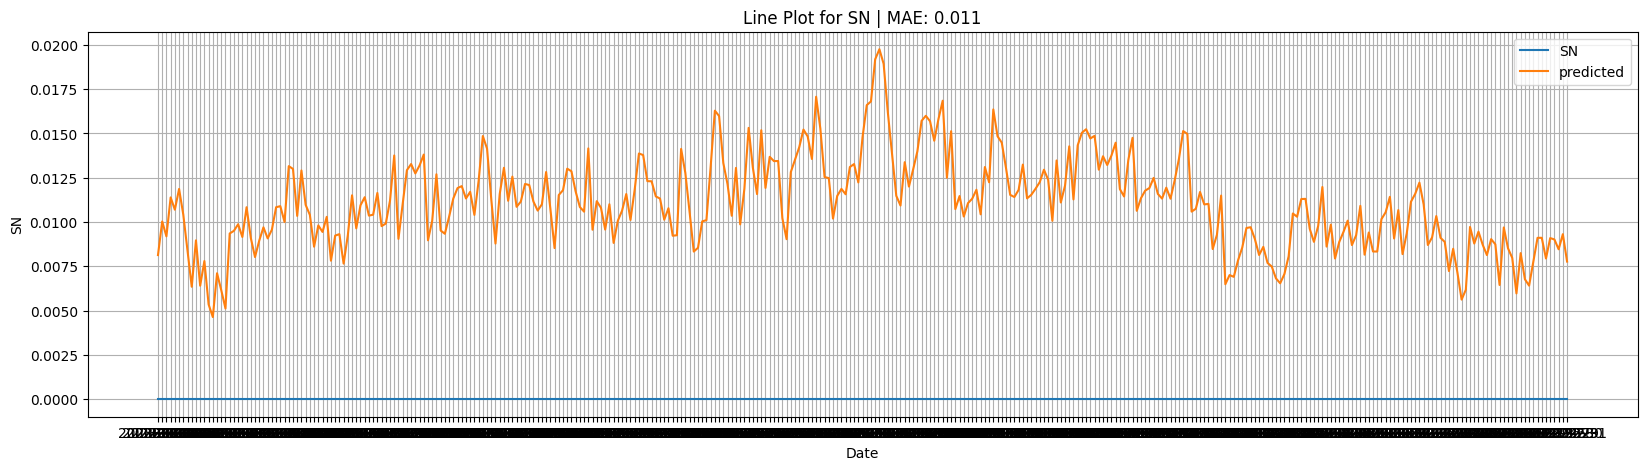

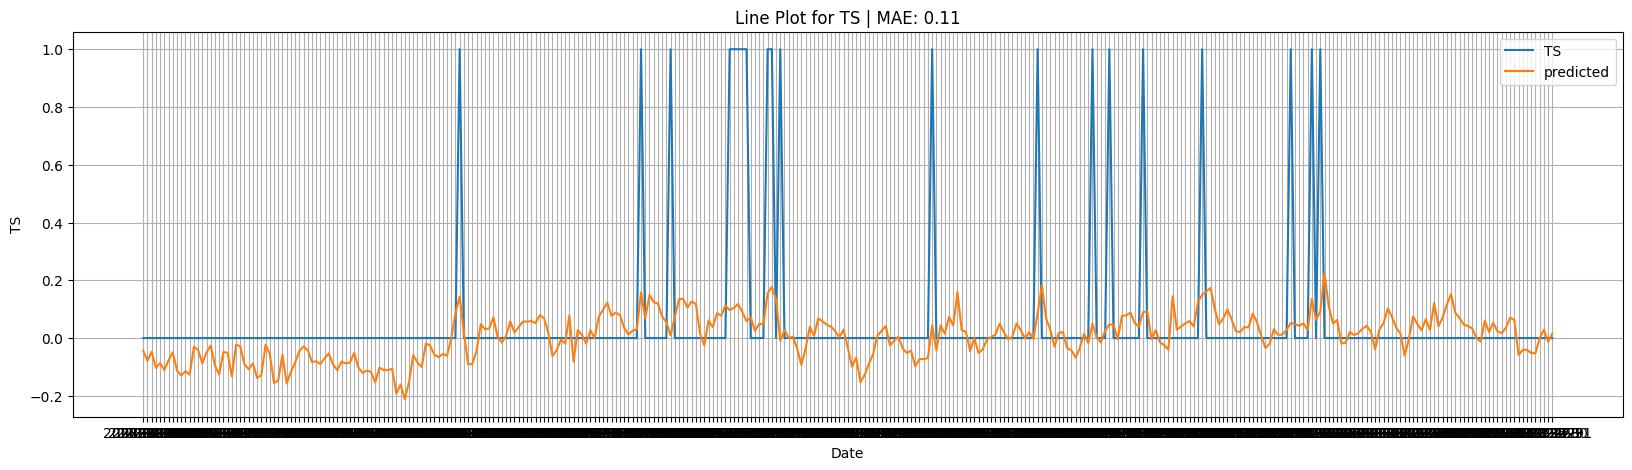

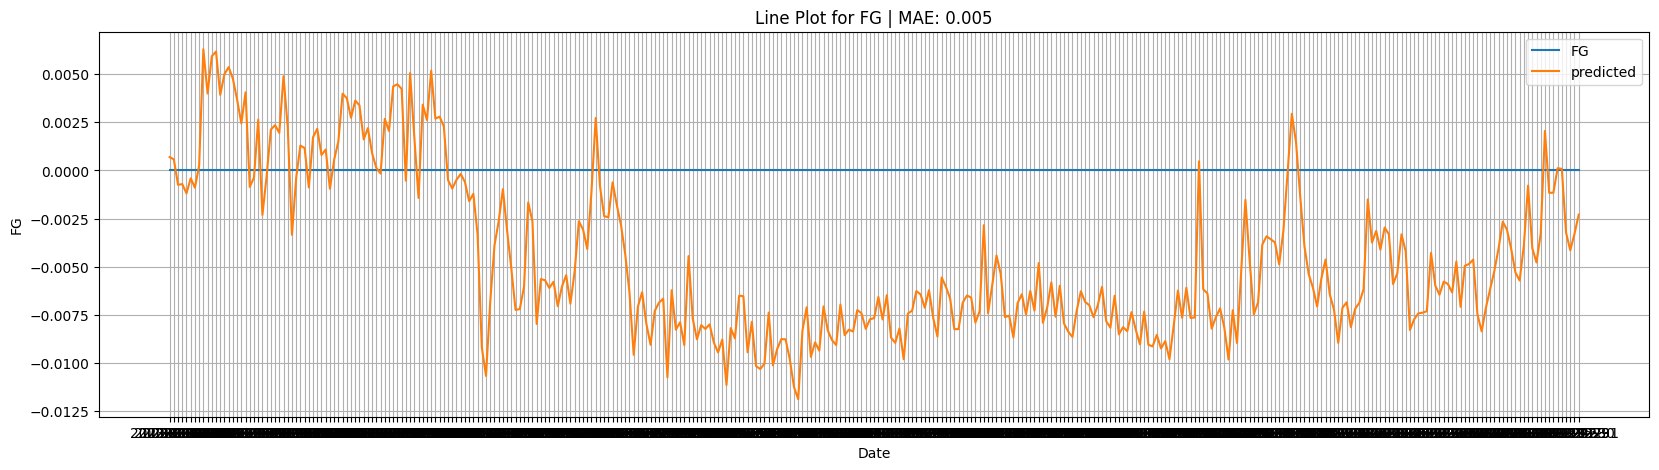

In [138]:
features = test.columns

plt.figure(figsize=(12, 8))

for feature in features:
    plt.figure(figsize=(20, 5))
    plt.plot(test.index, test[feature], label=feature)
    plt.plot(pred_df.index, pred_df[feature], label="predicted")
    plt.title(f'Line Plot for {feature} | MAE: {np.round(mean_absolute_error(test[feature],pred_df[feature]), 3)}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid()
    plt.show()